In [1]:
import pandas as pd
import utils
import numpy as np
import plotly.express as px

np.random.seed(9000)


In this notebook we calculate `mean average precision (mAP)` to compare the different experimental conditions. The following are the steps taken
1. Normalized, feature selected ORF, CRISPR and Compound profiles are read and the replicate plates are merged into a single dataframe, for each time point and cell line.
2. Negative control and empty wells are removed from the dataframe.
3. Average precision (AP) is computed for each replicate of each perturbation and the mean average precision (mAP) is computed for each condition.
4. The same is repeated for after shuffling the dataframe which is an estimate of the null distribution.
5. Table of mAP values is printed and bar plot of mAP values is plotted.

In [2]:
mean_average_precision_df = pd.DataFrame()
group_by_feature = 'Metadata_broad_sample'
batch = "2020_11_04_CPJUMP1"

experiment_df = (
    pd.read_csv('output/experiment-metadata.tsv', sep='\t')
    .query('Batch==@batch')
    .query('Density=="100"')
    .query('Antibiotics=="absent"')
)

experiment_df.drop(experiment_df[(experiment_df.Perturbation == "compound") & (experiment_df.Cell_line == "Cas9")].index, inplace=True)

In [3]:
for modality in experiment_df.Perturbation.unique():
    modality_df = experiment_df.query("Perturbation==@modality")
    for cell in modality_df.Cell_type.unique():
        cell_df = modality_df.query('Cell_type==@cell')
        for time_point in cell_df.Time.unique():
            time_df = cell_df.query("Time==@time_point")
            all_plates_df = pd.DataFrame()
            for plate in time_df.Assay_Plate_Barcode.unique():
                data_df = utils.load_data(batch, plate, "normalized_feature_select_negcon_batch.csv.gz")
                all_plates_df = utils.concat_profiles(all_plates_df, data_df)

            all_plates_df = utils.remove_negcon_empty_wells(all_plates_df)

            score = utils.MeanAveragePrecision(all_plates_df, all_plates_df, group_by_feature)

            mean_average_precision_df = mean_average_precision_df.append({'Description':f'{modality}_{cell}_{time_point}',
                                                                          'Modality':f'{modality}',
                                                                          'Cell':f'{cell}',
                                                                          'time':f'{time_point}',
                                                                          'mAP':f'{score.map:.3f}',
                                                                          'feature_set_replicates':'CP_True'}, ignore_index=True)

            all_plates_shuffled_df = utils.shuffle_profiles(all_plates_df)
            score_shuffled = utils.MeanAveragePrecision(all_plates_shuffled_df, all_plates_shuffled_df, group_by_feature)

            mean_average_precision_df = mean_average_precision_df.append({'Description':f'{modality}_{cell}_{time_point}',
                                                                          'Modality':f'{modality}',
                                                                          'Cell':f'{cell}',
                                                                          'time':f'{time_point}',
                                                                          'mAP':f'{score_shuffled.map:.3f}',
                                                                          'feature_set_replicates':'CP_Shuffled'}, ignore_index=True)


In [4]:
print(mean_average_precision_df[['Description','feature_set_replicates', 'mAP']].query('feature_set_replicates=="CP_True"').to_markdown(index=False))

| Description      | feature_set_replicates   |   mAP |
|:-----------------|:-------------------------|------:|
| compound_A549_24 | CP_True                  | 0.552 |
| compound_A549_48 | CP_True                  | 0.699 |
| compound_U2OS_24 | CP_True                  | 0.574 |
| compound_U2OS_48 | CP_True                  | 0.517 |
| crispr_U2OS_144  | CP_True                  | 0.308 |
| crispr_U2OS_96   | CP_True                  | 0.363 |
| crispr_A549_144  | CP_True                  | 0.304 |
| crispr_A549_96   | CP_True                  | 0.312 |
| orf_A549_96      | CP_True                  | 0.303 |
| orf_A549_48      | CP_True                  | 0.307 |
| orf_U2OS_48      | CP_True                  | 0.387 |
| orf_U2OS_96      | CP_True                  | 0.337 |


In [5]:
print(mean_average_precision_df[['Description','feature_set_replicates', 'mAP']].query('feature_set_replicates=="CP_Shuffled"').to_markdown(index=False))

| Description      | feature_set_replicates   |   mAP |
|:-----------------|:-------------------------|------:|
| compound_A549_24 | CP_Shuffled              | 0.253 |
| compound_A549_48 | CP_Shuffled              | 0.253 |
| compound_U2OS_24 | CP_Shuffled              | 0.271 |
| compound_U2OS_48 | CP_Shuffled              | 0.253 |
| crispr_U2OS_144  | CP_Shuffled              | 0.253 |
| crispr_U2OS_96   | CP_Shuffled              | 0.255 |
| crispr_A549_144  | CP_Shuffled              | 0.253 |
| crispr_A549_96   | CP_Shuffled              | 0.253 |
| orf_A549_96      | CP_Shuffled              | 0.265 |
| orf_A549_48      | CP_Shuffled              | 0.265 |
| orf_U2OS_48      | CP_Shuffled              | 0.267 |
| orf_U2OS_96      | CP_Shuffled              | 0.265 |


In [6]:
mean_average_precision_df['mAP'] = mean_average_precision_df['mAP'].astype(float)

mean_average_precision_df.loc[(mean_average_precision_df.Modality=='compound') & (mean_average_precision_df.time=='24'), 'time'] = 'short'
mean_average_precision_df.loc[(mean_average_precision_df.Modality=='compound') & (mean_average_precision_df.time=='48'), 'time'] = 'long'
mean_average_precision_df.loc[(mean_average_precision_df.Modality=='crispr') & (mean_average_precision_df.time=='96'), 'time'] = 'short'
mean_average_precision_df.loc[(mean_average_precision_df.Modality=='crispr') & (mean_average_precision_df.time=='144'), 'time'] = 'long'
mean_average_precision_df.loc[(mean_average_precision_df.Modality=='orf') & (mean_average_precision_df.time=='48'), 'time'] = 'short'
mean_average_precision_df.loc[(mean_average_precision_df.Modality=='orf') & (mean_average_precision_df.time=='96'), 'time'] = 'long'

plot_mAP_df = (
    mean_average_precision_df.rename(columns={'Modality':'Perturbation'})
)

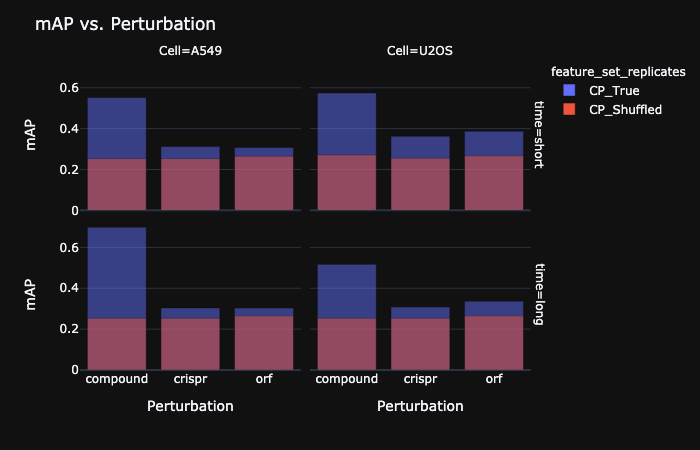

In [7]:
fig = px.bar(data_frame=plot_mAP_df,
             x='Perturbation',
             y='mAP',
             color='feature_set_replicates',
             barmode='overlay',
             facet_row='time',
             facet_col='Cell')
fig.update_layout(title='mAP vs. Perturbation',
                  yaxis=dict(title='mAP'),
                  yaxis3=dict(title='mAP'))
fig.show("png")
fig.write_image(f'figures/10.mAP_CellProfiler.png', width=640, height=480, scale=2)

In [8]:
print(plot_mAP_df[['Description','Perturbation','time', 'Cell', 'feature_set_replicates', 'mAP']].to_markdown(index=False))

| Description      | Perturbation   | time   | Cell   | feature_set_replicates   |   mAP |
|:-----------------|:---------------|:-------|:-------|:-------------------------|------:|
| compound_A549_24 | compound       | short  | A549   | CP_True                  | 0.552 |
| compound_A549_24 | compound       | short  | A549   | CP_Shuffled              | 0.253 |
| compound_A549_48 | compound       | long   | A549   | CP_True                  | 0.699 |
| compound_A549_48 | compound       | long   | A549   | CP_Shuffled              | 0.253 |
| compound_U2OS_24 | compound       | short  | U2OS   | CP_True                  | 0.574 |
| compound_U2OS_24 | compound       | short  | U2OS   | CP_Shuffled              | 0.271 |
| compound_U2OS_48 | compound       | long   | U2OS   | CP_True                  | 0.517 |
| compound_U2OS_48 | compound       | long   | U2OS   | CP_Shuffled              | 0.253 |
| crispr_U2OS_144  | crispr         | long   | U2OS   | CP_True                  | 0.308 |

In [9]:
plot_mAP_df.to_csv('output/cellprofiler_mAP.csv', index=False)